In [1]:
!apt-get update
!apt-get install xvfb
!apt-get install python3-tk
!pip install tk
!pip install gym[box2d]
!pip install gym-notebook-wrapper
!export MPLBACKEND=TKAgg

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,568 kB]
Hit:13

In [2]:
import gnwrapper
import gym
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torchvision.transforms as T
import numpy as np
import time
import datetime

In [3]:
env = gym.envs.make("LunarLander-v2")

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
def plot_res(values, avr, title=''):   
    '''
    학습 진행에 따라 보상의 변화와 보상의 히스토그램 관찰.
    Plot the reward curve and histogram of results over time.
    '''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(300, c='red',ls='--', label='goal')  # 목표 보상 값 표시
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()

    # 직선으로 변화 경향 표시
    # Calculate the trend
    try:
        # episode별 보상 값을 1차함수에 핏
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    

    # 히스토그램
    # Plot the histogram of results
    ax[1].hist(values[-30:])
    ax[1].axvline(avr, c='red', label='Average')
    ax[1].set_xlabel('Scores per Last 30 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [5]:
class DQN(nn.Module):
    ''' Deep Q Neural Network class. '''

    # 입력 레이어 2개 첫번째 레이어 64개 2번쨰 레이어 128개 마지막 레이어 2개
    def __init__(self, state_dim, action_dim, hidden_dims=[64, 128], lr=0.05):
        super().__init__()

        num_hidden_layer = len(hidden_dims)
        self.layers = nn.ModuleList([])

        if num_hidden_layer == 0:
            # input / output layer
            self.layers.append(torch.nn.Linear(state_dim, action_dim))
        else:
            # input layer
            self.layers.append(torch.nn.Linear(state_dim, hidden_dims[0]))
            self.layers.append(torch.nn.LeakyReLU())

            # hidden layers
            for i in range(num_hidden_layer-1):
                self.layers.append(torch.nn.Linear(hidden_dims[i], hidden_dims[i+1]))
                self.layers.append(torch.nn.LeakyReLU())

            # output layer
            self.layers.append(torch.nn.Linear(hidden_dims[-1], action_dim))


        # Adam 최적화
        self.optimizer = torch.optim.Adam(self.parameters(), lr)

        # Mean Squared Error 손실
        self.criterion = torch.nn.MSELoss()
    
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

def predict(dqn, state):
    """ Compute Q values for all actions using the DQL. """
    with torch.no_grad():
        return dqn(torch.Tensor(state))

In [32]:
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n

# Gamma (bellman equation)
gamma = 0.95

# Epsilon (epsilon-greedy method)
epsilon = 0.6
eps_decay = 0.97

# Number of episodes
episodes = 200

# Number of hidden nodes in the DQN
n_hiddens = [128, 128]

# Learning rate
lr = 0.005

In [6]:
from sys import set_coroutine_origin_tracking_depth
def update(dqn, state, y):
    """Update the weights of the network given a training sample. """
    y_pred = dqn(torch.Tensor(state))
    loss = dqn.criterion(y_pred, torch.Tensor(y))

    dqn.optimizer.zero_grad()
    loss.backward()
    dqn.optimizer.step()


def q_learning(env, dqn, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               title = 'Lunar Lander', verbose=True): # verbose 정보 출력
    """Deep Q Learning algorithm using the DQN. """
    final = []
    episode_i=0
    
    # reward avr count
    avrMaxCount = 30
    valueSumForAvr = 0
    valueIndexForAvr = 0
    valueAvr = 0.0
    allOfTotal = 0.0

    startTimeOfEpisodeProcess = 0.0
    endTimeOfEpisodeProcess = 0.0
    
    startTime = time.time()
    for episode in range(episodes):
        episode_i+=1

        # Reset state
        state = env.reset()
        done = False
        total = 0.0

        while not done:
            # Epsilon-greedy 행동 선택
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = predict(dqn, state)
                action = torch.argmax(q_values).item() # 텐서 형식으로 저장된 것을 일반적인 숫자로 바꿈
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total 
            total += reward
            allOfTotal += reward
            valueSumForAvr += reward
            q_values = predict(dqn, state).tolist()
             
            if done:
                # Episode 가 끝날때는 현재 reward만으로 학습 (next_state 가 없으므로)
                q_values[action] = reward
                # Update network weights
                update(dqn, state, q_values)
                break


            # 현재 행동의 결과 학습
            # Update network weights using the last step only
            q_values_next = predict(dqn, next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            update(dqn, state, q_values)

            state = next_state
      

        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, valueAvr, title) #그래프용

        if (episode+1) >= avrMaxCount:
          valueSumForAvr -= final[valueIndexForAvr]
          valueIndexForAvr += 1
          valueAvr = float(valueSumForAvr/avrMaxCount)
        else:
          valueAvr = float(valueSumForAvr/(episode+1))

        if verbose:
            print("[진행된 에피소드 : {}], [진행된 에피소드의 보상 : {}] \n[최근 30개의 에피소드 보상 평균 : {}]"
            .format(episode_i, total, valueAvr))
       
    endTime = time.time()

    print("[전체 보상 합 :", allOfTotal, "]", "\n[학습까지 총 걸린 시간 :", str(datetime.timedelta(seconds = endTime-startTime)).split(".")[0],
          "]")


    return final

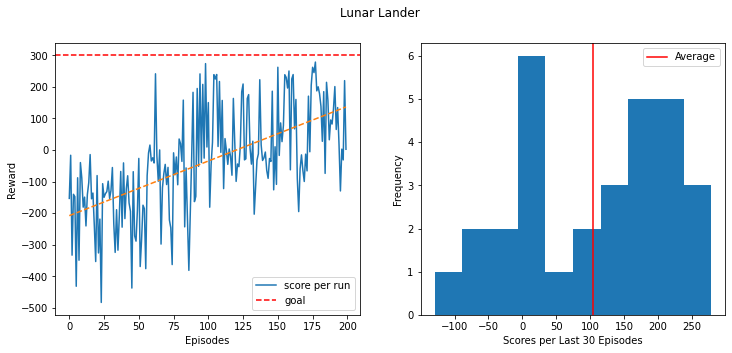

[진행된 에피소드 : 200], [진행된 에피소드의 보상 : 2.4936406501431065] 
[최근 30개의 에피소드 보상 평균 : 104.29068754877389]
[전체 보상 합 : -7116.41381582726 ] 
[학습까지 총 걸린 시간 : 0:03:45 ]


In [33]:
simple_dqn = DQN(n_state, n_action, n_hiddens, lr)
simple = q_learning(env, simple_dqn, episodes, gamma=gamma, epsilon=epsilon, eps_decay=eps_decay)

In [34]:
env_ani = gnwrapper.Monitor(gym.make("LunarLander-v2", render_mode="single_rgb_array"))
maxReward = 0
index = 0


for i in range(100, 1500, 50):
  observation = env_ani.reset(seed=i)
  totalReward = 0

  for t in range(2000):
    qs = predict(simple_dqn, torch.tensor([observation]))
    action = np.argmax(qs)
    observation, reward, done, _ = env_ani.step(action.item())
    totalReward += reward

    if done:
      if maxReward < totalReward:
        maxReward = totalReward
        index = i
      break

env_ani = gnwrapper.Monitor(gym.make("LunarLander-v2", render_mode="single_rgb_array"))
observation = env_ani.reset(seed=index)


for t in range(2000):
  qs = predict(simple_dqn, torch.tensor([observation]))
  action = np.argmax(qs)
  observation, reward, done, _ = env_ani.step(action.item())
  if done:
    print("[최적의 시드 : %d]" % index)
    print("[해당 시드에서 얻은 보상 : %d]" % maxReward)
    break

env_ani.display()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initial

[최적의 시드 : 1150]
[해당 시드에서 얻은 보상 : 239]


'rl-video-episode-0.mp4'